In [4]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [5]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [6]:
import pandas as pd
import numpy as np
from glob import glob
from scipy.stats import spearmanr

from REVIVAL.util import get_file_name

/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [7]:
# cols will be ev, af3, unweight ev + af3, weighted ev + af3, naive all, learned all

# navie ensemble 
ensemble_score = []

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    lib_name = get_file_name(f)
    if lib_name == "ParLQ":
        lib_name = "ParLQ-a"
    df = pd.read_csv(f, index_col=0)
    # put nan to 0
    df = df.fillna(0)

    # convert each column that is not fitness to ranking
    for c in df.columns:
        if c != "fitness":
            df[c] = df[c].rank()

    # navie ensemble for all
    y_true = df["fitness"].values

    # sum up all columns
    y_pred = df.drop(columns=["fitness"]).sum(axis=1)

    y_top2 = df[["EVmutation", "AF3"]].sum(axis=1)
    y_esmif_af = df["ESM-IF"] + df["AF3"]
    y_ev_esmif = df["EVmutation"] + df["ESM-IF"]
    y_top3 = df[["EVmutation", "AF3", "ESM-IF"]].sum(axis=1)

    # save to dict
    ensemble_score.append(
        {
            "Library": lib_name,
            "EVmutation": spearmanr(y_true, df["EVmutation"].values)[0],
            "AF3": spearmanr(y_true, df["AF3"].values)[0],
            "ESM-IF": spearmanr(y_true, df["ESM-IF"].values)[0],
            "EVmutation + AF3$_{uw}$": spearmanr(y_true, y_top2)[0],
            "AF3 + ESM-IF$_{uw}$": spearmanr(y_true, y_esmif_af.values)[0],
            "EVmutation + ESM-IF$_{uw}$": spearmanr(y_true, y_ev_esmif.values)[0],
            "EVmutation + AF3 + ESM-IF$_{uw}$": spearmanr(y_true, y_top3)[0],
            "All$_{uw}$": spearmanr(y_true, y_pred)[0],
        }
    )

In [8]:
# ParLQ-f from lin_rho_pairwise_df for all
# Rma-CB from /disk2/fli/REVIVAL2/zs/lincomb/lin_params_EVmutation_AF3.npz

In [9]:
chosen_lib = "ParLQ-f"
intercept, weights = np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_params.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"]
intercept, weights 

(26.161200618131705,
 array([-6.17606913, 10.66979437, -7.7613554 ,  6.01554364, -3.66054528,
        -2.79707653,  1.52553801, -1.14420113,  2.39054622,  2.18857787,
         4.07049746,  0.12910479,  2.13006802,  1.520902  , -0.41676693,
         2.28120538]))

In [10]:

from sklearn.preprocessing import StandardScaler

# use given weights to predict all

def inference_linear_model(X, w_0, w):
    y = np.dot(X, w) + w_0
    return y

In [11]:

FINAL_COL_ORDER = [
    "Library",
    "Hamming distance",
    "EVmutation",
    "ESM2",
    "ESM-IF",
    "CoVES",
    r"ΔΔ$G_f$",  # "ΔΔG",
    "Vina",
    "GALigandDock",
    "AF3",
    "Chai-1",
    "LigandMPNN",
    "FlowSite",
    "Bond distance",
    "Hydrogen bonds",
    "Hydrophobicity",
    "Active-site volume",
]


LIB_ORDER = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ-a",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]

In [12]:
weighted_res = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[FINAL_COL_ORDER[1:]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_linear_model(X, intercept, weights)

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    weighted_res[file_name] = spearmanr(y, y_all)[0]

weighted_res

{'ParLQ-a': 0.42454208278992633,
 'ParLQ-b': 0.5064919035392255,
 'ParLQ-c': 0.5125816212772735,
 'ParLQ-d': 0.5022774327122153,
 'ParLQ-e': 0.3868067638458907,
 'ParLQ-f': 0.6204650422041728,
 'ParLQ-g': 0.4874502309284918,
 'ParLQ-h': 0.5198439241917504,
 'ParLQ-i': 0.3995699952221691,
 'PfTrpB-4bromo': 0.44976729382515906,
 'PfTrpB-4cyano': 0.3886415074928844,
 'PfTrpB-56chloro': 0.2241544564268651,
 'PfTrpB-5bromo': 0.30794837964105454,
 'PfTrpB-5chloro': 0.2747823023006609,
 'PfTrpB-5cyano': 0.34922814256550583,
 'PfTrpB-5iodo': 0.2997136586536813,
 'PfTrpB-6chloro': 0.3740784725486336,
 'PfTrpB-7bromo': 0.49757605832728935,
 'PfTrpB-7iodo': 0.45714349400199755,
 'PfTrpB-7methyl': 0.3628013442611707,
 'Rma-CB': 0.21975405911608556,
 'Rma-CSi': 0.08999641527741807}

In [13]:
import numpy as np

In [14]:
best_learned = {
    "ParLQ-b": 0.1523184608891614,
    "ParLQ-c": 0.23802451833489488,
    "ParLQ-d": 0.35744545309762704,
    "ParLQ-e": 0.33196499387887807,
    "ParLQ-f": 0.3130300448422614,
    "ParLQ-g": 0.3051704504830828,
    "ParLQ-h": 0.2650432594512944,
    "ParLQ-i": 0.22467132244160679,
    "ParLQ-a": 0.3199954896114968,
    "PfTrpB-4bromo": 0.5038194247236192,
    "PfTrpB-4cyano": 0.405931723877782,
    "PfTrpB-56chloro": 0.3761525463398954,
    "PfTrpB-5bromo": 0.49751637248086983,
    "PfTrpB-5chloro": 0.5090232907443473,
    "PfTrpB-5cyano": 0.43977258138390984,
    "PfTrpB-5iodo": 0.4703739583690546,
    "PfTrpB-6chloro": 0.5777199379565172,
    "PfTrpB-7bromo": 0.5317021032942703,
    "PfTrpB-7iodo": 0.5791796995727267,
    "PfTrpB-7methyl": 0.4557902678234629,
    "Rma-CB": 0.3968486489108766,
    "Rma-CSi": 0.36660699495028093,
}

In [15]:
np.array([v for k, v in best_learned.items() if k != "Rma-CB"]).mean()

0.39148823307366853

In [16]:
len(best_learned)

22

In [17]:
chosen_lib = "ParLQ-e"
intercept, weights = np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_params_AF3_ESM-IF.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"]
esmif_af3_linreg = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[["AF3", "ESM-IF"]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_linear_model(X, intercept, weights)

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    esmif_af3_linreg[file_name] = spearmanr(y, y_all)[0]

esmif_af3_linreg

{'ParLQ-a': 0.44495397941925124,
 'ParLQ-b': 0.04487993661421389,
 'ParLQ-c': 0.19404363752189843,
 'ParLQ-d': 0.31267717789456917,
 'ParLQ-e': 0.37856497278916407,
 'ParLQ-f': 0.2504379678292722,
 'ParLQ-g': 0.28186016881669057,
 'ParLQ-h': 0.21788501353718745,
 'ParLQ-i': 0.21522535435578916,
 'PfTrpB-4bromo': 0.5259667513620859,
 'PfTrpB-4cyano': 0.4470499982853813,
 'PfTrpB-56chloro': 0.4263939220140812,
 'PfTrpB-5bromo': 0.5197485680779046,
 'PfTrpB-5chloro': 0.5422457525131621,
 'PfTrpB-5cyano': 0.47627545192018195,
 'PfTrpB-5iodo': 0.5135497753849321,
 'PfTrpB-6chloro': 0.584368373934458,
 'PfTrpB-7bromo': 0.5210520288582662,
 'PfTrpB-7iodo': 0.6370423142575593,
 'PfTrpB-7methyl': 0.48600613833544803,
 'Rma-CB': 0.33926458909297424,
 'Rma-CSi': 0.3218356062435111}

In [18]:
chosen_lib = "ParLQ-f"
intercept, weights = np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_params_EVmutation_AF3_ESM-IF.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"]
esmif_ev_af3_linreg = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[["EVmutation", "AF3", "ESM-IF"]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_linear_model(X, intercept, weights)

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    esmif_ev_af3_linreg[file_name] = spearmanr(y, y_all)[0]

esmif_ev_af3_linreg

{'ParLQ-a': 0.39256974486281815,
 'ParLQ-b': 0.13359664595043763,
 'ParLQ-c': 0.23911450867972608,
 'ParLQ-d': 0.3551680203854117,
 'ParLQ-e': 0.37046651722907603,
 'ParLQ-f': 0.27687529861442906,
 'ParLQ-g': 0.290667303710782,
 'ParLQ-h': 0.2636566332218506,
 'ParLQ-i': 0.26685777990125814,
 'PfTrpB-4bromo': 0.4900488774059746,
 'PfTrpB-4cyano': 0.39185213127121843,
 'PfTrpB-56chloro': 0.3295753142685912,
 'PfTrpB-5bromo': 0.4411838081547249,
 'PfTrpB-5chloro': 0.4438904795554266,
 'PfTrpB-5cyano': 0.4235170362458108,
 'PfTrpB-5iodo': 0.45414337642742025,
 'PfTrpB-6chloro': 0.5099307529600339,
 'PfTrpB-7bromo': 0.4694812383097301,
 'PfTrpB-7iodo': 0.5952801646723535,
 'PfTrpB-7methyl': 0.4207143102088406,
 'Rma-CB': 0.37362511121449876,
 'Rma-CSi': 0.36090538964153546}

In [19]:
chosen_lib = "ParLQ-f"
intercept, weights = np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_params_EVmutation_ESM-IF.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"]
esmif_ev_linreg = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[["EVmutation", "ESM-IF"]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_linear_model(X, intercept, weights)

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    esmif_ev_linreg[file_name] = spearmanr(y, y_all)[0]

esmif_ev_linreg

{'ParLQ-a': 0.2762028909008511,
 'ParLQ-b': -0.13775337535296062,
 'ParLQ-c': -0.038795986622073585,
 'ParLQ-d': -0.05647396082178691,
 'ParLQ-e': 0.0857624054888367,
 'ParLQ-f': 0.06908743430482561,
 'ParLQ-g': 0.06518553909858257,
 'ParLQ-h': -0.08595317725752509,
 'ParLQ-i': -0.09517439082656474,
 'PfTrpB-4bromo': 0.5150103252316891,
 'PfTrpB-4cyano': 0.3673313672370633,
 'PfTrpB-56chloro': 0.4556834948078685,
 'PfTrpB-5bromo': 0.49256840692073156,
 'PfTrpB-5chloro': 0.5237801609556036,
 'PfTrpB-5cyano': 0.40374704388872573,
 'PfTrpB-5iodo': 0.4760956414389082,
 'PfTrpB-6chloro': 0.5392348811844028,
 'PfTrpB-7bromo': 0.5150208039088445,
 'PfTrpB-7iodo': 0.5440593121459701,
 'PfTrpB-7methyl': 0.47975120880628236,
 'Rma-CB': 0.13312635142720763,
 'Rma-CSi': 0.06639479355163766}

In [20]:
def inference_piecewise_model(X, params):
    """
    Computes y_hat for all data points under the piecewise model.
    params structure:
        [w0, w1, ..., w_n, p1_1, p1_2, p2_1, p2_2, ..., pn_1, pn_2]
    where p_j_1 and p_j_2 define alpha_{j1} and alpha_{j2} via reparameterization:
        alpha_{j1} = params[ n+1 + 2*(j-1) ]
        alpha_{j2} = alpha_{j1} + exp( params[ n+1 + 2*(j-1) + 1] )
    """
    try:
        m, n = X.shape
    except ValueError:
        print("X is not 2D")

    # Parse out w0, w1..w_n
    w0 = params[0]
    w = params[1 : n + 1]  # shape (n,)

    # Parse out alpha params in reparameterized form
    alpha_list = []
    for j in range(n):
        base_index = n + 1 + 2 * j
        alpha1 = params[base_index]
        alpha2 = alpha1 + np.exp(params[base_index + 1])  # ensures alpha2 > alpha1
        alpha_list.append((alpha1, alpha2))

    y_hat = np.zeros(m)
    for i in range(m):
        # Start with intercept
        pred_i = w0
        # Add contribution from each feature
        for j in range(n):
            alpha1, alpha2 = alpha_list[j]
            pred_i += w[j] * piecewise_transform(X[i, j], alpha1, alpha2)
        y_hat[i] = pred_i

    return y_hat

def piecewise_transform(x, alpha1, alpha2):
    """
    Single-feature piecewise-linear transform phi(x; alpha1, alpha2).
    """
    if x < alpha1:
        return 0.0
    elif x >= alpha2:
        return 1.0
    else:
        # linear transition
        return (x - alpha1) / (alpha2 - alpha1)


In [21]:
chosen_lib = "ParLQ-g"
top2_linpiece = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[["EVmutation", "AF3"]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_piecewise_model(X, np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_piece_params_EVmutation_AF3.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"])

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    top2_linpiece[file_name] = spearmanr(y, y_all)[0]

top2_linpiece

{'ParLQ-a': 0.36726145821099937,
 'ParLQ-b': 0.24331184374149936,
 'ParLQ-c': 0.3376587343510153,
 'ParLQ-d': 0.43227295326209414,
 'ParLQ-e': 0.31916046781118806,
 'ParLQ-f': 0.3040626874507821,
 'ParLQ-g': 0.34744535402742227,
 'ParLQ-h': 0.35950383015289356,
 'ParLQ-i': 0.2754359381961836,
 'PfTrpB-4bromo': 0.43341613046886096,
 'PfTrpB-4cyano': 0.35122591266471437,
 'PfTrpB-56chloro': 0.3366332133038393,
 'PfTrpB-5bromo': 0.4203083164134853,
 'PfTrpB-5chloro': 0.47986261774307826,
 'PfTrpB-5cyano': 0.33079867743061114,
 'PfTrpB-5iodo': 0.3580104856375479,
 'PfTrpB-6chloro': 0.5239513679690623,
 'PfTrpB-7bromo': 0.4530295535625385,
 'PfTrpB-7iodo': 0.4676873122038494,
 'PfTrpB-7methyl': 0.3854013596415499,
 'Rma-CB': 0.360859955595129,
 'Rma-CSi': 0.2972969792564188}

In [22]:
chosen_lib = "Rma-CSi"
topall_linpiece = {}

for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
    df = pd.read_csv(f)
    # fill nan with 0
    df = df.fillna(0)

    X = df[["EVmutation", "AF3"]].to_numpy()
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    y = df["fitness"].to_numpy()

    y_all = inference_piecewise_model(X, np.load("/disk2/fli/REVIVAL2/zs/lincomb/lin_piece_params.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"])

    file_name = get_file_name(f)
    if file_name == "ParLQ":
        file_name = "ParLQ-a"
    # calc rho
    topall_linpiece[file_name] = spearmanr(y, y_all)[0]

topall_linpiece

{'ParLQ-a': 0.35249241860097585,
 'ParLQ-b': 0.19977461835390364,
 'ParLQ-c': 0.2639372793661836,
 'ParLQ-d': 0.3669195093048279,
 'ParLQ-e': 0.33935653507567426,
 'ParLQ-f': 0.2838575083955303,
 'ParLQ-g': 0.29844268393077417,
 'ParLQ-h': 0.2787951188551866,
 'ParLQ-i': 0.28437524976693285,
 'PfTrpB-4bromo': 0.18188728375657875,
 'PfTrpB-4cyano': 0.24706201466621272,
 'PfTrpB-56chloro': 0.1606179358627146,
 'PfTrpB-5bromo': 0.21794714783571004,
 'PfTrpB-5chloro': 0.22446021228835017,
 'PfTrpB-5cyano': 0.21417234458344,
 'PfTrpB-5iodo': 0.21768048815424576,
 'PfTrpB-6chloro': 0.26180186913738684,
 'PfTrpB-7bromo': 0.191565295717187,
 'PfTrpB-7iodo': 0.3016768400922557,
 'PfTrpB-7methyl': 0.2294187267768683,
 'Rma-CB': 0.3631012261457647,
 'Rma-CSi': 0.39604003303838764}

In [24]:
# chosen_lib = "ParLQ-e"
# top2_log = {}

# for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
#     df = pd.read_csv(f)
#     # fill nan with 0
#     df = df.fillna(0)

#     X = df[["EVmutation", "AF3"]].to_numpy()
    
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     y = df["fitness"].to_numpy()

#     y_all = inference_piecewise_model(X, np.load("/disk2/fli/REVIVAL2/zs/lincomb/logistic_params_EVmutation_AF3.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"])

#     file_name = get_file_name(f)
#     if file_name == "ParLQ":
#         file_name = "ParLQ-a"
#     # calc rho
#     top2_log[file_name] = spearmanr(y, y_all)[0]

# top2_log

In [25]:
for k in np.load("/disk2/fli/REVIVAL2/zs/lincomb/logistic_params.npz", allow_pickle=True).keys():
    print(k)

intercept
weights
ab_pairs
objective_value
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-5iodo
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-5bromo
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-5cyano
train_fold_PfTrpB-5chloro_test_fold_ParLQ-c
train_fold_PfTrpB-5chloro_test_fold_ParLQ-g
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-56chloro
train_fold_PfTrpB-5chloro_test_fold_ParLQ-i
train_fold_PfTrpB-5chloro_test_fold_ParLQ-d
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-6chloro
train_fold_PfTrpB-5chloro_test_fold_ParLQ-f
train_fold_PfTrpB-5chloro_test_fold_Rma-CB
train_fold_PfTrpB-5chloro_test_fold_ParLQ-b
train_fold_PfTrpB-5chloro_test_fold_Rma-CSi
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-4cyano
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-4bromo
train_fold_PfTrpB-5chloro_test_fold_ParLQ-a
train_fold_PfTrpB-5chloro_test_fold_ParLQ-e
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-7iodo
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-7methyl
train_fold_PfTrpB-5chloro_test_fold_PfTrpB-7bromo
train_fold_PfTrp

In [82]:
mlp_all = pd.read_csv("/disk2/fli/REVIVAL2/zs/mlpcomb/MLP_rho_df_epochs5000_patience10000_batchsize32_penaltylasso_layers1_hiddendim32.csv", index_col=0)
mlp_all

,ParLQ-a,PfTrpB-5iodo,PfTrpB-5bromo,PfTrpB-5cyano,ParLQ-c,ParLQ-g,PfTrpB-56chloro,ParLQ-i,ParLQ-d,PfTrpB-6chloro,...,ParLQ-b,Rma-CSi,PfTrpB-4cyano,PfTrpB-4bromo,ParLQ-e,PfTrpB-7iodo,PfTrpB-7methyl,PfTrpB-7bromo,ParLQ-h,PfTrpB-5chloro
ParLQ-a,0.847932,0.169879,0.181122,-0.007552,-0.037060,0.041535,0.099135,0.126708,-0.101672,0.150483,...,0.056681,0.016434,0.076813,0.099175,0.012247,0.154916,0.068182,0.160553,0.108409,0.164857
PfTrpB-5iodo,0.204634,0.657048,0.545331,0.480516,-0.175792,-0.079519,0.502082,-0.152126,-0.252445,0.578614,...,-0.052493,0.205480,0.387664,0.544473,-0.207598,0.557252,0.554257,0.603161,-0.135722,0.576383
PfTrpB-5bromo,0.301568,0.425009,0.569300,0.484843,-0.008505,0.228715,0.464314,-0.053273,0.073547,0.658340,...,-0.175984,0.247724,0.424353,0.554833,0.135747,0.659201,0.607004,0.683361,-0.011435,0.599870
PfTrpB-5cyano,0.171920,0.276052,0.401982,0.459638,-0.093056,-0.064803,0.267483,-0.120704,-0.149944,0.436337,...,-0.184632,0.100727,0.315944,0.407550,-0.009779,0.571329,0.553749,0.421957,0.062000,0.434712
ParLQ-c,-0.014662,-0.341439,-0.373377,-0.425026,0.815592,0.240436,-0.420076,0.441376,0.609890,-0.436528,...,0.608061,0.008683,-0.274114,-0.403371,0.351992,-0.407441,-0.434287,-0.364164,0.451394,-0.474549
ParLQ-g,0.167053,0.128334,0.124795,0.206272,0.396671,0.677258,0.111629,0.496241,0.474025,0.188784,...,0.317329,0.173178,0.085776,0.247678,0.370793,0.313720,0.146837,0.248387,0.462749,0.101790
PfTrpB-56chloro,0.212892,0.487955,0.572619,0.482281,-0.111499,-0.098296,0.566971,-0.156952,-0.180873,0.592884,...,-0.190939,0.193472,0.350338,0.497876,-0.059970,0.647749,0.588951,0.596557,-0.082784,0.577560
ParLQ-i,0.387080,-0.080282,-0.063254,-0.045830,0.639783,0.363354,-0.084079,0.868196,0.522408,-0.054050,...,0.555967,0.026178,0.073677,0.168598,0.317910,0.039741,-0.076932,-0.046227,0.541010,-0.096317
ParLQ-d,0.384802,-0.164877,-0.147179,-0.163255,0.563481,0.357127,-0.188410,0.414477,0.702500,-0.164675,...,0.544237,0.155091,-0.068429,-0.210715,0.435294,-0.150268,-0.183002,-0.137229,0.501370,-0.133434
PfTrpB-6chloro,0.292934,0.509269,0.575140,0.503532,-0.172193,-0.056904,0.531672,-0.239831,-0.143000,0.798962,...,-0.169709,0.299373,0.414948,0.574602,-0.066946,0.728763,0.706214,0.712563,-0.096656,0.657353


In [83]:
# get row index Rma-CSi
mlp_all.loc["Rma-CSi"].to_frame().reset_index().rename(columns={"index": "Library", "Rma-CSi": "All$_{1l-nn}$"})

,Library,All$_{1l-nn}$
0,ParLQ-a,0.386433
1,PfTrpB-5iodo,0.161841
2,PfTrpB-5bromo,0.298624
3,PfTrpB-5cyano,0.176974
4,ParLQ-c,0.275522
5,ParLQ-g,0.330180
6,PfTrpB-56chloro,0.268221
7,ParLQ-i,0.168864
8,ParLQ-d,0.364899
9,PfTrpB-6chloro,0.453151


In [84]:
mlp_ev_af3 = pd.read_csv("/disk2/fli/REVIVAL2/zs/mlpcomb/all_campaigns_combclean_evmut_af3_MLP_rho_df_epochs_5000_patience50000_batchsize32_neur32_lay1_rho_pairwise_df.csv", index_col=0)
mlp_ev_af3

,ParLQ-a,PfTrpB-5iodo,PfTrpB-5bromo,PfTrpB-5cyano,ParLQ-c,ParLQ-g,PfTrpB-56chloro,ParLQ-i,ParLQ-d,PfTrpB-6chloro,...,ParLQ-b,Rma-CSi,PfTrpB-4cyano,PfTrpB-4bromo,ParLQ-e,PfTrpB-7iodo,PfTrpB-7methyl,PfTrpB-7bromo,ParLQ-h,PfTrpB-5chloro
Library,,,,,,,,,,,,,,,,,,,,,
ParLQ,0.585972,0.062445,0.085755,0.047948,0.099610,0.215888,0.054282,0.247812,0.197229,0.120316,...,0.098026,0.080160,0.211791,-0.002019,0.204052,0.044753,0.116424,0.114097,0.163434,0.113359
PfTrpB-5iodo,0.156961,0.536839,0.495478,0.391199,0.009468,0.166119,0.356386,0.004539,0.060201,0.491214,...,0.144164,0.282607,0.351249,0.497249,0.122884,0.503978,0.394635,0.528801,0.144084,0.498683
PfTrpB-5bromo,0.018039,0.451418,0.558651,0.433444,0.176311,0.178366,0.457275,-0.017662,0.161268,0.621702,...,0.025434,0.312809,0.371878,0.531348,0.155732,0.585435,0.491619,0.626331,0.191003,0.589728
PfTrpB-5cyano,0.091382,0.457737,0.460007,0.437311,0.112686,0.188829,0.379925,0.042619,0.113410,0.563750,...,0.059317,0.282647,0.357705,0.476750,0.154044,0.503159,0.492786,0.518876,0.009412,0.518524
ParLQ-c,0.344264,0.122681,0.091985,0.023950,0.637548,0.373558,0.089393,0.289220,0.512629,0.148785,...,0.209486,0.143551,0.160235,0.018496,0.387142,0.084103,0.123264,0.144940,0.416326,0.174372
ParLQ-g,0.399202,0.269743,0.252833,0.200467,0.369447,0.426688,0.205324,0.252765,0.439433,0.339781,...,0.284036,0.212765,0.234936,0.181799,0.330396,0.323135,0.267225,0.342673,0.408586,0.330094
PfTrpB-56chloro,-0.066147,0.451829,0.480470,0.248929,0.046831,0.106602,0.488153,-0.156396,0.082816,0.540260,...,0.010798,0.220891,0.223874,0.491893,-0.045450,0.490016,0.341439,0.488338,0.073611,0.514799
ParLQ-i,0.260910,0.003135,0.031665,-0.042704,0.342723,0.248314,0.045981,0.601279,0.319621,0.037119,...,0.282906,0.168675,0.046596,-0.077355,0.230880,0.018997,-0.011737,-0.019544,0.331216,0.094460
ParLQ-d,0.356311,0.183096,0.169783,0.133047,0.549047,0.417196,0.170252,0.329960,0.669788,0.255352,...,0.341347,0.280165,0.205480,0.153732,0.429299,0.267411,0.169509,0.296866,0.473644,0.255362


In [85]:
mlp_ev_af3.loc["Rma-CB"].to_frame().reset_index().rename(columns={"index": "Library", "Rma-CB": "EVmutation + AF3$_{1l-nn}$"})

,Library,EVmutation + AF3$_{1l-nn}$
0,ParLQ-a,0.216635
1,PfTrpB-5iodo,0.459658
2,PfTrpB-5bromo,0.506673
3,PfTrpB-5cyano,0.411211
4,ParLQ-c,0.170625
5,ParLQ-g,0.252518
6,PfTrpB-56chloro,0.427775
7,ParLQ-i,0.136520
8,ParLQ-d,0.278850
9,PfTrpB-6chloro,0.570554


In [86]:
mlp_all_af3 = pd.read_csv("/disk2/fli/REVIVAL2/zs/mlpcomb_af3/all_campaigns_jointsepaf3cols_MLP_rho_df_epochs_5000_patience10000_batchsize32_neur32_lay1_rho_pairwise_df.csv", index_col=0)
mlp_all_af3

,PfTrpB-5iodo,PfTrpB-5bromo,PfTrpB-5cyano,PfTrpB-56chloro,PfTrpB-6chloro,PfTrpB-4cyano,PfTrpB-4bromo,PfTrpB-7iodo,PfTrpB-7methyl,PfTrpB-7bromo,...,ParLQ-c,ParLQ-g,ParLQ-i,ParLQ-d,ParLQ-f,Rma-CB,ParLQ-b,Rma-CSi,ParLQ-e,ParLQ-h
Library,,,,,,,,,,,,,,,,,,,,,
PfTrpB-5iodo,0.731227,0.358329,0.137084,0.293567,0.210626,0.085096,0.225711,0.073068,0.258876,-0.051800,...,0.096417,0.209396,0.117662,-0.006482,0.279073,0.219930,-0.099324,0.155977,0.095764,0.161538
PfTrpB-5bromo,0.323605,0.883902,0.155530,0.314266,0.344578,0.284044,0.270579,0.266581,0.269574,0.124556,...,0.202819,0.191703,0.210049,0.161634,0.357557,0.077255,0.170107,0.196509,0.294929,0.165329
PfTrpB-5cyano,0.191872,0.142735,0.682904,0.178544,0.070515,0.137284,0.147390,0.088883,-0.031022,0.029545,...,-0.028938,-0.246998,-0.002628,-0.208027,-0.146138,0.011293,-0.036113,-0.191615,-0.207829,-0.241328
PfTrpB-56chloro,0.220650,0.281194,0.157216,0.713546,0.259526,0.168014,0.239863,0.223730,0.180822,0.101844,...,0.095987,-0.122583,0.077082,0.148702,0.105893,-0.001903,0.255527,-0.110391,0.007772,0.066316
PfTrpB-6chloro,0.243619,0.303137,0.077142,0.215883,0.906131,0.312245,0.235609,0.302933,0.299432,0.344085,...,0.193598,0.001529,0.248734,0.102787,0.082593,0.104157,0.017105,0.163226,0.179663,0.232139
PfTrpB-4cyano,0.255439,0.204087,0.272670,0.124830,0.212593,0.861263,0.355763,0.251323,0.306678,0.369012,...,0.010432,-0.114811,0.004730,-0.205797,0.051871,-0.160696,-0.045421,-0.082523,-0.259676,-0.067622
PfTrpB-4bromo,0.215064,0.186132,0.110492,0.118055,0.218984,0.290523,0.855557,0.230582,0.314699,0.269191,...,0.250104,-0.076700,0.125020,0.270282,0.210878,0.020028,0.154755,0.020748,0.042993,0.132219
PfTrpB-7iodo,0.196311,0.321863,0.207574,0.199435,0.288155,0.290792,0.342955,0.858085,0.418373,0.277016,...,0.240850,0.062574,0.328173,0.180156,0.118411,-0.021808,0.241624,0.088417,0.050828,0.148368
PfTrpB-7methyl,0.210785,0.336372,0.147221,0.283336,0.264525,0.257396,0.305049,0.370803,0.892737,0.322861,...,0.060647,-0.060153,0.084026,0.199968,0.040341,-0.016406,0.090747,0.064497,-0.048782,0.088103


In [87]:
mlp_all_af3.loc["Rma-CB"].to_frame().reset_index().rename(columns={"index": "Library", "Rma-CB": "All AF3$_{1l-nn}$"})

,Library,All AF3$_{1l-nn}$
0,PfTrpB-5iodo,0.115558
1,PfTrpB-5bromo,0.171659
2,PfTrpB-5cyano,-0.064802
3,PfTrpB-56chloro,0.133234
4,PfTrpB-6chloro,0.065791
5,PfTrpB-4cyano,-0.020914
6,PfTrpB-4bromo,0.004970
7,PfTrpB-7iodo,-0.090670
8,PfTrpB-7methyl,0.112568
9,PfTrpB-7bromo,-0.087224


In [26]:
# chosen_lib = "ParLQ-e"
# top2_log = {}

# for f in sorted(glob("/disk2/fli/REVIVAL2/zs/comb/minimal/*.csv")):
#     df = pd.read_csv(f)
#     # fill nan with 0
#     df = df.fillna(0)

#     X = df[["EVmutation", "AF3"]].to_numpy()
    
#     scaler = StandardScaler()
#     X = scaler.fit_transform(X)

#     y = df["fitness"].to_numpy()

#     y_all = inference_piecewise_model(X, np.load("/disk2/fli/REVIVAL2/zs/lincomb/logistic_params_EVmutation_AF3.npz", allow_pickle=True)[f"train_fold_{chosen_lib}_test_fold_{chosen_lib}"])

#     file_name = get_file_name(f)
#     if file_name == "ParLQ":
#         file_name = "ParLQ-a"
#     # calc rho
#     top2_log[file_name] = spearmanr(y, y_all)[0]

# top2_log

In [88]:
merged_df = pd.merge(
    pd.merge(
        pd.DataFrame(ensemble_score),
        pd.DataFrame(
            list(best_learned.items()), columns=["Library", "EVmutation + AF3$_{w}$"]
        ),
        on="Library",
    ),
    pd.DataFrame(
        list(weighted_res.items()), columns=["Library", "All$_{w}$"]
    ),
    on="Library",
) # .set_index("Library").reindex(LIB_ORDER)# [["EVmutation", "AF3", "EVmutation + AF3$_{uw}$", "EVmutation + AF3$_{w}$", "All$_{uw}$", "All$_{w}$"]]
merged_df

,Library,EVmutation,AF3,ESM-IF,EVmutation + AF3$_{uw}$,AF3 + ESM-IF$_{uw}$,EVmutation + ESM-IF$_{uw}$,EVmutation + AF3 + ESM-IF$_{uw}$,All$_{uw}$,EVmutation + AF3$_{w}$,All$_{w}$
0,ParLQ-a,0.064764,0.356036,0.278441,0.306634,0.442433,0.204007,0.325853,0.312371,0.319995,0.424542
1,ParLQ-b,0.069212,0.193525,-0.138534,0.196330,0.004802,-0.020259,0.039961,-0.063068,0.152318,0.506492
2,ParLQ-c,0.109442,0.256742,-0.040022,0.297884,0.137178,0.054367,0.182499,0.106005,0.238025,0.512582
3,ParLQ-d,0.071439,0.365860,-0.055805,0.359845,0.212122,0.011675,0.191657,0.257020,0.357445,0.502277
4,ParLQ-e,0.003063,0.335681,0.088398,0.292459,0.322780,0.063768,0.226200,0.259317,0.331965,0.386807
5,ParLQ-f,0.187746,0.278623,0.069135,0.367588,0.215466,0.172578,0.266012,0.188179,0.313030,0.620465
6,ParLQ-g,0.127933,0.289401,0.066109,0.325122,0.224386,0.120194,0.236302,0.257130,0.305170,0.487450
7,ParLQ-h,0.052008,0.275381,-0.084647,0.266398,0.118721,0.012957,0.139833,0.117601,0.265043,0.519844
8,ParLQ-i,-0.070933,0.283123,-0.094187,0.178256,0.127413,-0.087774,0.052806,0.054269,0.224671,0.399570
9,PfTrpB-4bromo,0.474594,0.198803,0.514151,0.463090,0.479890,0.527743,0.533105,0.556906,0.503819,0.449767


In [89]:
merged_df = pd.merge(merged_df, pd.merge(
    pd.merge(
        pd.DataFrame(list(esmif_af3_linreg.items()), columns=["Library", "AF3 + ESM-IF$_{w}$"]),
        pd.DataFrame(
            list(esmif_ev_af3_linreg.items()), columns=["Library", "EVmutation + AF3 + ESM-IF$_{w}$"]
        ),
        on="Library",
    ),
    pd.DataFrame(
        list(esmif_ev_linreg.items()), columns=["Library", "EVmutation + ESM-IF$_{w}$"]
    ),
    on="Library",
), on="Library")
merged_df

,Library,EVmutation,AF3,ESM-IF,EVmutation + AF3$_{uw}$,AF3 + ESM-IF$_{uw}$,EVmutation + ESM-IF$_{uw}$,EVmutation + AF3 + ESM-IF$_{uw}$,All$_{uw}$,EVmutation + AF3$_{w}$,All$_{w}$,AF3 + ESM-IF$_{w}$,EVmutation + AF3 + ESM-IF$_{w}$,EVmutation + ESM-IF$_{w}$
0,ParLQ-a,0.064764,0.356036,0.278441,0.306634,0.442433,0.204007,0.325853,0.312371,0.319995,0.424542,0.444954,0.392570,0.276203
1,ParLQ-b,0.069212,0.193525,-0.138534,0.196330,0.004802,-0.020259,0.039961,-0.063068,0.152318,0.506492,0.044880,0.133597,-0.137753
2,ParLQ-c,0.109442,0.256742,-0.040022,0.297884,0.137178,0.054367,0.182499,0.106005,0.238025,0.512582,0.194044,0.239115,-0.038796
3,ParLQ-d,0.071439,0.365860,-0.055805,0.359845,0.212122,0.011675,0.191657,0.257020,0.357445,0.502277,0.312677,0.355168,-0.056474
4,ParLQ-e,0.003063,0.335681,0.088398,0.292459,0.322780,0.063768,0.226200,0.259317,0.331965,0.386807,0.378565,0.370467,0.085762
5,ParLQ-f,0.187746,0.278623,0.069135,0.367588,0.215466,0.172578,0.266012,0.188179,0.313030,0.620465,0.250438,0.276875,0.069087
6,ParLQ-g,0.127933,0.289401,0.066109,0.325122,0.224386,0.120194,0.236302,0.257130,0.305170,0.487450,0.281860,0.290667,0.065186
7,ParLQ-h,0.052008,0.275381,-0.084647,0.266398,0.118721,0.012957,0.139833,0.117601,0.265043,0.519844,0.217885,0.263657,-0.085953
8,ParLQ-i,-0.070933,0.283123,-0.094187,0.178256,0.127413,-0.087774,0.052806,0.054269,0.224671,0.399570,0.215225,0.266858,-0.095174
9,PfTrpB-4bromo,0.474594,0.198803,0.514151,0.463090,0.479890,0.527743,0.533105,0.556906,0.503819,0.449767,0.525967,0.490049,0.515010


In [90]:
merged_df = pd.merge(
    merged_df, 
    pd.merge(
        pd.DataFrame(list(top2_linpiece.items()), columns=["Library", "EVmutation + AF3$_{lp}$"]),
        pd.DataFrame(
            list(topall_linpiece.items()), columns=["Library", "All$_{lp}$"]
        ),
        on="Library",
    ),on ="Library")
merged_df

,Library,EVmutation,AF3,ESM-IF,EVmutation + AF3$_{uw}$,AF3 + ESM-IF$_{uw}$,EVmutation + ESM-IF$_{uw}$,EVmutation + AF3 + ESM-IF$_{uw}$,All$_{uw}$,EVmutation + AF3$_{w}$,All$_{w}$,AF3 + ESM-IF$_{w}$,EVmutation + AF3 + ESM-IF$_{w}$,EVmutation + ESM-IF$_{w}$,EVmutation + AF3$_{lp}$,All$_{lp}$
0,ParLQ-a,0.064764,0.356036,0.278441,0.306634,0.442433,0.204007,0.325853,0.312371,0.319995,0.424542,0.444954,0.392570,0.276203,0.367261,0.352492
1,ParLQ-b,0.069212,0.193525,-0.138534,0.196330,0.004802,-0.020259,0.039961,-0.063068,0.152318,0.506492,0.044880,0.133597,-0.137753,0.243312,0.199775
2,ParLQ-c,0.109442,0.256742,-0.040022,0.297884,0.137178,0.054367,0.182499,0.106005,0.238025,0.512582,0.194044,0.239115,-0.038796,0.337659,0.263937
3,ParLQ-d,0.071439,0.365860,-0.055805,0.359845,0.212122,0.011675,0.191657,0.257020,0.357445,0.502277,0.312677,0.355168,-0.056474,0.432273,0.366920
4,ParLQ-e,0.003063,0.335681,0.088398,0.292459,0.322780,0.063768,0.226200,0.259317,0.331965,0.386807,0.378565,0.370467,0.085762,0.319160,0.339357
5,ParLQ-f,0.187746,0.278623,0.069135,0.367588,0.215466,0.172578,0.266012,0.188179,0.313030,0.620465,0.250438,0.276875,0.069087,0.304063,0.283858
6,ParLQ-g,0.127933,0.289401,0.066109,0.325122,0.224386,0.120194,0.236302,0.257130,0.305170,0.487450,0.281860,0.290667,0.065186,0.347445,0.298443
7,ParLQ-h,0.052008,0.275381,-0.084647,0.266398,0.118721,0.012957,0.139833,0.117601,0.265043,0.519844,0.217885,0.263657,-0.085953,0.359504,0.278795
8,ParLQ-i,-0.070933,0.283123,-0.094187,0.178256,0.127413,-0.087774,0.052806,0.054269,0.224671,0.399570,0.215225,0.266858,-0.095174,0.275436,0.284375
9,PfTrpB-4bromo,0.474594,0.198803,0.514151,0.463090,0.479890,0.527743,0.533105,0.556906,0.503819,0.449767,0.525967,0.490049,0.515010,0.433416,0.181887


In [91]:
merged_df = pd.merge(merged_df, pd.merge(
    pd.merge(
        mlp_all.loc["Rma-CSi"].to_frame().reset_index().rename(columns={"index": "Library", "Rma-CSi": "All$_{1l-nn}$"}),
        mlp_ev_af3.loc["Rma-CB"].to_frame().reset_index().rename(columns={"index": "Library", "Rma-CB": "EVmutation + AF3$_{1l-nn}$"}),
        on="Library",
    ),
    mlp_all_af3.loc["Rma-CB"].to_frame().reset_index().rename(columns={"index": "Library", "Rma-CB": "All AF3$_{1l-nn}$"}),
    on="Library",
), on="Library")
merged_df

,Library,EVmutation,AF3,ESM-IF,EVmutation + AF3$_{uw}$,AF3 + ESM-IF$_{uw}$,EVmutation + ESM-IF$_{uw}$,EVmutation + AF3 + ESM-IF$_{uw}$,All$_{uw}$,EVmutation + AF3$_{w}$,All$_{w}$,AF3 + ESM-IF$_{w}$,EVmutation + AF3 + ESM-IF$_{w}$,EVmutation + ESM-IF$_{w}$,EVmutation + AF3$_{lp}$,All$_{lp}$,All$_{1l-nn}$,EVmutation + AF3$_{1l-nn}$,All AF3$_{1l-nn}$
0,ParLQ-a,0.064764,0.356036,0.278441,0.306634,0.442433,0.204007,0.325853,0.312371,0.319995,0.424542,0.444954,0.392570,0.276203,0.367261,0.352492,0.386433,0.216635,0.092209
1,ParLQ-b,0.069212,0.193525,-0.138534,0.196330,0.004802,-0.020259,0.039961,-0.063068,0.152318,0.506492,0.044880,0.133597,-0.137753,0.243312,0.199775,0.200200,0.058497,0.094601
2,ParLQ-c,0.109442,0.256742,-0.040022,0.297884,0.137178,0.054367,0.182499,0.106005,0.238025,0.512582,0.194044,0.239115,-0.038796,0.337659,0.263937,0.275522,0.170625,0.076493
3,ParLQ-d,0.071439,0.365860,-0.055805,0.359845,0.212122,0.011675,0.191657,0.257020,0.357445,0.502277,0.312677,0.355168,-0.056474,0.432273,0.366920,0.364899,0.278850,0.194967
4,ParLQ-e,0.003063,0.335681,0.088398,0.292459,0.322780,0.063768,0.226200,0.259317,0.331965,0.386807,0.378565,0.370467,0.085762,0.319160,0.339357,0.289729,0.315959,0.256698
5,ParLQ-f,0.187746,0.278623,0.069135,0.367588,0.215466,0.172578,0.266012,0.188179,0.313030,0.620465,0.250438,0.276875,0.069087,0.304063,0.283858,0.299331,0.254278,0.266651
6,ParLQ-g,0.127933,0.289401,0.066109,0.325122,0.224386,0.120194,0.236302,0.257130,0.305170,0.487450,0.281860,0.290667,0.065186,0.347445,0.298443,0.330180,0.252518,0.275442
7,ParLQ-h,0.052008,0.275381,-0.084647,0.266398,0.118721,0.012957,0.139833,0.117601,0.265043,0.519844,0.217885,0.263657,-0.085953,0.359504,0.278795,0.333795,0.166078,0.252795
8,ParLQ-i,-0.070933,0.283123,-0.094187,0.178256,0.127413,-0.087774,0.052806,0.054269,0.224671,0.399570,0.215225,0.266858,-0.095174,0.275436,0.284375,0.168864,0.136520,0.267144
9,PfTrpB-4bromo,0.474594,0.198803,0.514151,0.463090,0.479890,0.527743,0.533105,0.556906,0.503819,0.449767,0.525967,0.490049,0.515010,0.433416,0.181887,0.181163,0.476735,0.004970


In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [93]:
merged_df.columns

Index(['Library', 'EVmutation', 'AF3', 'ESM-IF', 'EVmutation + AF3$_{uw}$',
       'AF3 + ESM-IF$_{uw}$', 'EVmutation + ESM-IF$_{uw}$',
       'EVmutation + AF3 + ESM-IF$_{uw}$', 'All$_{uw}$',
       'EVmutation + AF3$_{w}$', 'All$_{w}$', 'AF3 + ESM-IF$_{w}$',
       'EVmutation + AF3 + ESM-IF$_{w}$', 'EVmutation + ESM-IF$_{w}$',
       'EVmutation + AF3$_{lp}$', 'All$_{lp}$', 'All$_{1l-nn}$',
       'EVmutation + AF3$_{1l-nn}$', 'All AF3$_{1l-nn}$'],
      dtype='object')

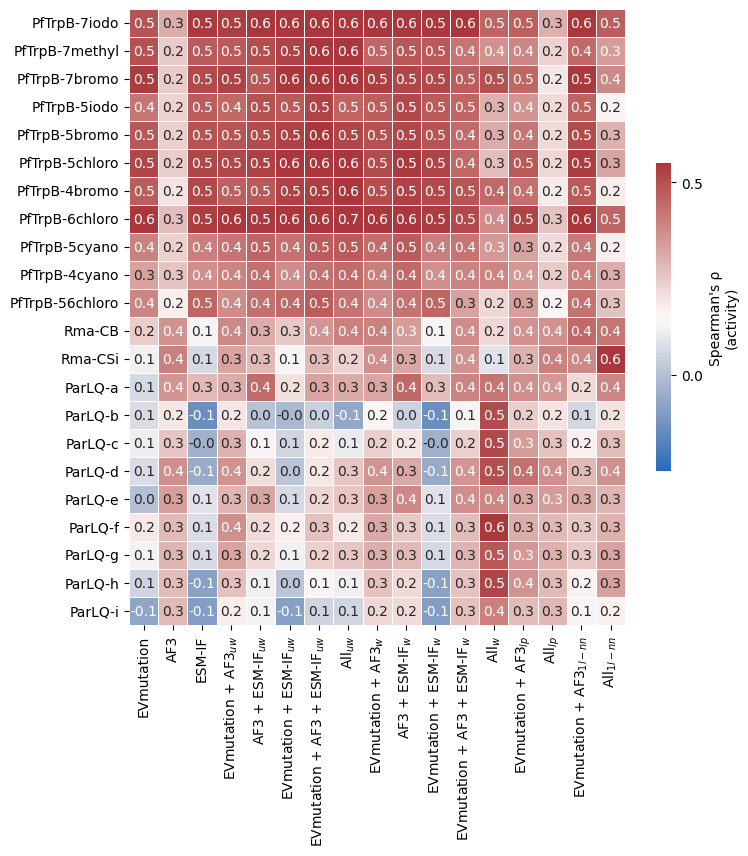

In [94]:

merged_df = merged_df[["Library", 'EVmutation', 'AF3', 'ESM-IF', 'EVmutation + AF3$_{uw}$',
       'AF3 + ESM-IF$_{uw}$', 'EVmutation + ESM-IF$_{uw}$',
       'EVmutation + AF3 + ESM-IF$_{uw}$', 'All$_{uw}$',
       'EVmutation + AF3$_{w}$', 'AF3 + ESM-IF$_{w}$', 'EVmutation + ESM-IF$_{w}$',
       'EVmutation + AF3 + ESM-IF$_{w}$', 'All$_{w}$',
       'EVmutation + AF3$_{lp}$', 'All$_{lp}$', 'EVmutation + AF3$_{1l-nn}$', 'All$_{1l-nn}$', ]].set_index("Library").reindex(LIB_ORDER)

# Set the figure size
plt.figure(figsize=(8, 8))
# Create a heatmap
sns.heatmap(
    merged_df,
    # .reindex(LIB_ORDER),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Spearman's ρ\n(activity)", "ticks": [0, 0.5], "shrink": 0.5},
    vmin=-0.25,
    vmax=0.55
)
# take away y label
plt.ylabel("")
# Show the plot
# plt.title("ZS Summary: Spearman correlation")
plt.savefig("figs/lincomb/zs_sumlincomb_fit_rho_all.svg", format="svg", dpi=300, bbox_inches="tight")

In [95]:
merged_df

,EVmutation,AF3,ESM-IF,EVmutation + AF3$_{uw}$,AF3 + ESM-IF$_{uw}$,EVmutation + ESM-IF$_{uw}$,EVmutation + AF3 + ESM-IF$_{uw}$,All$_{uw}$,EVmutation + AF3$_{w}$,AF3 + ESM-IF$_{w}$,EVmutation + ESM-IF$_{w}$,EVmutation + AF3 + ESM-IF$_{w}$,All$_{w}$,EVmutation + AF3$_{lp}$,All$_{lp}$,EVmutation + AF3$_{1l-nn}$,All$_{1l-nn}$
Library,,,,,,,,,,,,,,,,,
PfTrpB-7iodo,0.493195,0.308005,0.542172,0.534033,0.590136,0.556069,0.604010,0.636052,0.579180,0.637042,0.544059,0.595280,0.457143,0.467687,0.301677,0.566853,0.468991
PfTrpB-7methyl,0.498362,0.245480,0.477408,0.476195,0.503357,0.525945,0.550526,0.561480,0.455790,0.486006,0.479751,0.420714,0.362801,0.385401,0.229419,0.444029,0.342720
PfTrpB-7bromo,0.539337,0.246079,0.511127,0.525774,0.483952,0.589752,0.566709,0.629002,0.531702,0.521052,0.515021,0.469481,0.497576,0.453030,0.191565,0.545711,0.380578
PfTrpB-5iodo,0.419296,0.233702,0.474848,0.446358,0.494995,0.479050,0.522340,0.457824,0.470374,0.513550,0.476096,0.454143,0.299714,0.358010,0.217680,0.459658,0.161841
PfTrpB-5bromo,0.487423,0.236553,0.490748,0.490624,0.508149,0.525427,0.563333,0.521125,0.497516,0.519749,0.492568,0.441184,0.307948,0.420308,0.217947,0.506673,0.298624
PfTrpB-5chloro,0.521059,0.241473,0.521673,0.515796,0.528936,0.561268,0.591284,0.564059,0.509023,0.542246,0.523780,0.443890,0.274782,0.479863,0.224460,0.538464,0.321907
PfTrpB-4bromo,0.474594,0.198803,0.514151,0.463090,0.479890,0.527743,0.533105,0.556906,0.503819,0.525967,0.515010,0.490049,0.449767,0.433416,0.181887,0.476735,0.181163
PfTrpB-6chloro,0.569694,0.273612,0.536471,0.552219,0.542531,0.595567,0.618108,0.657513,0.577720,0.584368,0.539235,0.509931,0.374078,0.523951,0.261802,0.570554,0.453151
PfTrpB-5cyano,0.396476,0.236277,0.401769,0.421051,0.457360,0.428298,0.473762,0.476859,0.439773,0.476275,0.403747,0.423517,0.349228,0.330799,0.214172,0.411211,0.176974


In [98]:
merged_df_copy = merged_df.copy()

In [99]:
# Define columns
first_8_cols = merged_df_copy.columns[:8]  # First 8 columns where we take mean over all rows
next_cols = merged_df_copy.columns[8:]  # Columns starting from the 9th column

# Define exclusions per column (column_name: row_index_to_exclude)
exclusions = {
    "EVmutation + AF3$_{w}$": "Rma-CB",
    "AF3 + ESM-IF$_{w}$": "ParLQ-e",
    "EVmutation + AF3 + ESM-IF$_{w}$": "ParLQ-f",
    "EVmutation + ESM-IF$_{w}$": "ParLQ-f",
    "All$_{w}$": "ParLQ-f",
    "EVmutation + AF3$_{lp}$": "ParLQ-g",
    "All$_{lp}$": "Rma-CSi",
    "EVmutation + AF3$_{1l-nn}": "Rma-CB",
    "All$_{1l-nn}$": "Rma-CSi",
}

# Compute means for the first 8 columns (all rows included)
new_row = merged_df_copy[first_8_cols].mean().to_dict()

# Compute means for the next columns (excluding specific rows)
for col in next_cols:
    row_to_exclude = exclusions.get(col, None)  # Get row to exclude if defined
    if row_to_exclude in merged_df_copy.index:  # Only exclude if the row exists
        new_row[col] = merged_df_copy.loc[merged_df_copy.index != row_to_exclude, col].mean()
    else:
        new_row[col] = merged_df_copy[col].mean()  # Default to mean of all rows if no exclusion

# Add new row to DataFrame
merged_df_copy.loc["All-avg or test-avg"] = new_row
merged_df_copy

,EVmutation,AF3,ESM-IF,EVmutation + AF3$_{uw}$,AF3 + ESM-IF$_{uw}$,EVmutation + ESM-IF$_{uw}$,EVmutation + AF3 + ESM-IF$_{uw}$,All$_{uw}$,EVmutation + AF3$_{w}$,AF3 + ESM-IF$_{w}$,EVmutation + ESM-IF$_{w}$,EVmutation + AF3 + ESM-IF$_{w}$,All$_{w}$,EVmutation + AF3$_{lp}$,All$_{lp}$,EVmutation + AF3$_{1l-nn}$,All$_{1l-nn}$
Library,,,,,,,,,,,,,,,,,
PfTrpB-7iodo,0.493195,0.308005,0.542172,0.534033,0.590136,0.556069,0.604010,0.636052,0.579180,0.637042,0.544059,0.595280,0.457143,0.467687,0.301677,0.566853,0.468991
PfTrpB-7methyl,0.498362,0.245480,0.477408,0.476195,0.503357,0.525945,0.550526,0.561480,0.455790,0.486006,0.479751,0.420714,0.362801,0.385401,0.229419,0.444029,0.342720
PfTrpB-7bromo,0.539337,0.246079,0.511127,0.525774,0.483952,0.589752,0.566709,0.629002,0.531702,0.521052,0.515021,0.469481,0.497576,0.453030,0.191565,0.545711,0.380578
PfTrpB-5iodo,0.419296,0.233702,0.474848,0.446358,0.494995,0.479050,0.522340,0.457824,0.470374,0.513550,0.476096,0.454143,0.299714,0.358010,0.217680,0.459658,0.161841
PfTrpB-5bromo,0.487423,0.236553,0.490748,0.490624,0.508149,0.525427,0.563333,0.521125,0.497516,0.519749,0.492568,0.441184,0.307948,0.420308,0.217947,0.506673,0.298624
PfTrpB-5chloro,0.521059,0.241473,0.521673,0.515796,0.528936,0.561268,0.591284,0.564059,0.509023,0.542246,0.523780,0.443890,0.274782,0.479863,0.224460,0.538464,0.321907
PfTrpB-4bromo,0.474594,0.198803,0.514151,0.463090,0.479890,0.527743,0.533105,0.556906,0.503819,0.525967,0.515010,0.490049,0.449767,0.433416,0.181887,0.476735,0.181163
PfTrpB-6chloro,0.569694,0.273612,0.536471,0.552219,0.542531,0.595567,0.618108,0.657513,0.577720,0.584368,0.539235,0.509931,0.374078,0.523951,0.261802,0.570554,0.453151
PfTrpB-5cyano,0.396476,0.236277,0.401769,0.421051,0.457360,0.428298,0.473762,0.476859,0.439773,0.476275,0.403747,0.423517,0.349228,0.330799,0.214172,0.411211,0.176974


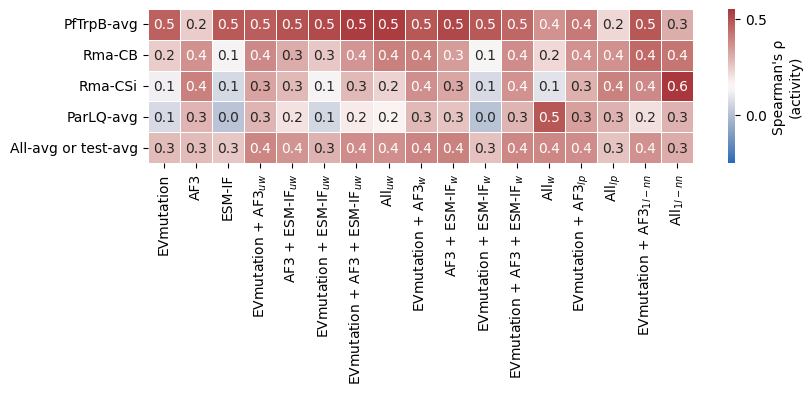

In [100]:
# merged_df = merged_df.set_index("Library").reindex(LIB_ORDER)

groups = {
    "PfTrpB-avg": [c for c in LIB_ORDER if c.startswith("PfTrpB")],
    "ParLQ-avg": [c for c in LIB_ORDER if c.startswith("ParLQ")],
}

for new_row, rows in groups.items():
    merged_df_copy.loc[new_row] = merged_df_copy.loc[rows].mean()

# Set the figure size
plt.figure(figsize=(8.8, 2))
# Create a heatmap
sns.heatmap(
    merged_df_copy.loc[["PfTrpB-avg", "Rma-CB", "Rma-CSi", "ParLQ-avg", "All-avg or test-avg"]],
    # .reindex(LIB_ORDER),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Spearman's ρ\n(activity)", "ticks": [0, 0.5]},
    vmin=-0.25,
    vmax=0.55
)
# take away y label
plt.ylabel("")
# Show the plot
# plt.title("ZS Summary: Spearman correlation")
plt.savefig("figs/lincomb/zs_sumlincomb_morewall_fit_rho.svg", format="svg", dpi=300, bbox_inches="tight")

In [67]:
merged_df.columns

Index(['EVmutation', 'AF3', 'ESM-IF', 'EVmutation + AF3$_{uw}$',
       'AF3 + ESM-IF$_{uw}$', 'EVmutation + ESM-IF$_{uw}$',
       'EVmutation + AF3 + ESM-IF$_{uw}$', 'All$_{uw}$',
       'EVmutation + AF3$_{w}$', 'AF3 + ESM-IF$_{w}$',
       'EVmutation + ESM-IF$_{w}$', 'EVmutation + AF3 + ESM-IF$_{w}$',
       'All$_{w}$', 'EVmutation + AF3$_{lp}$', 'All$_{lp}$',
       'EVmutation + AF3$_{mlp}$', 'All$_{mlp}$'],
      dtype='object')